# Part 3 - Analyse

## This example uses multithreading. It is only usefull when pyo3d releases the GIL

It is now time to analyze the model

__warning:__ 

Some of the code in this worksheet may (will) look intimidating. Do not be intimidated. A lot of the code in this worksheet is included for completeness and can be replaced by standard functions. In other words: we will put it in a cage for you and so you only need to feed it.

In [1]:
from DAVE import *
from DAVE.jupyter import *

Equilibrium-core version = 1.0
default resource folders:
C:\Users\beneden\Miniconda3\envs\DAVE\lib\site-packages\DAVE\resources
C:\Users\beneden\DAVE_models
Blender found at: C:\Program Files\Blender Foundation\Blender 2.83\blender.exe
embedWindow(verbose=True): could not load k3d module, try:
> pip install k3d      # and if necessary:
> conda install nodejs


Load and plot the model that we created during the previous step

Loading C:\Users\beneden\DAVE_models\workflow_4p_lift.dave
Solved to 0.00013284753367770463.


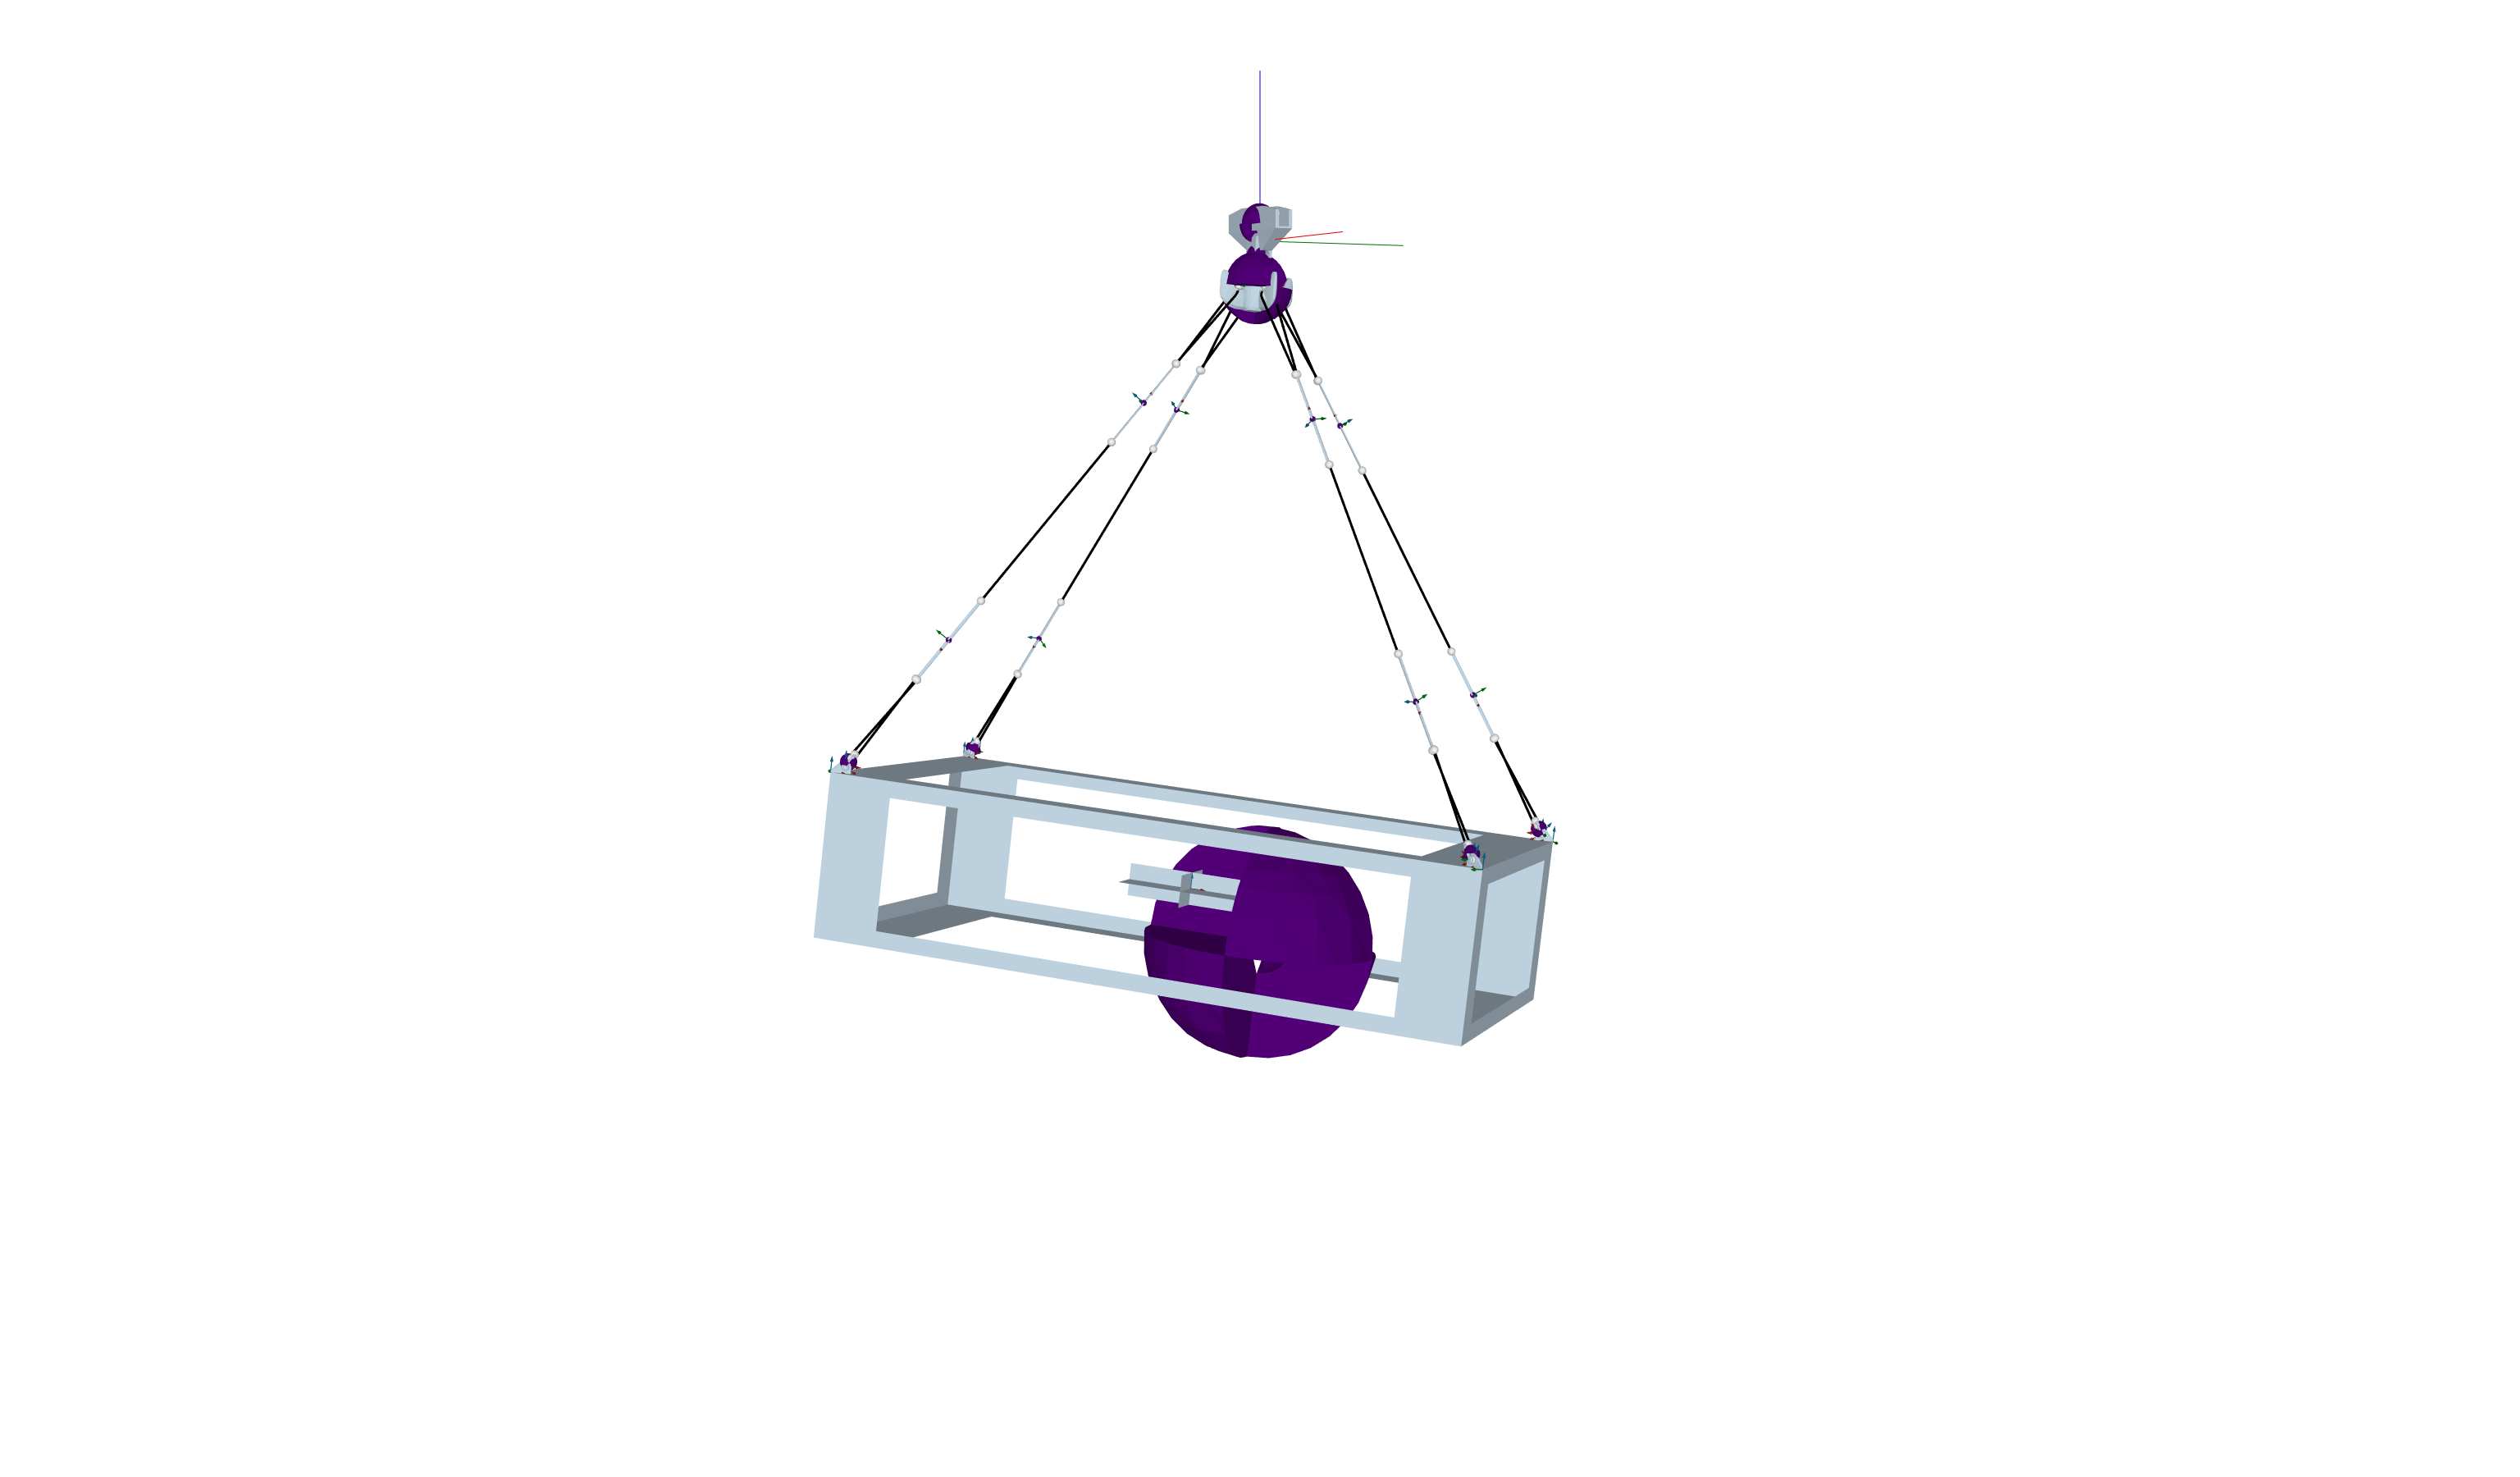

In [2]:
s = Scene('workflow_4p_lift')
s.solve_statics()
show(s, sea=False, camera_pos = (150, -80, -10), lookat = (0,0,-30))

The tilt looks terrible! # TODO

# Loadcases

Analyzing a model typically means setting up a number of load-cases and checking that the model is able to withstand each and every one of them.

For example the Skew-Load-Factor may be engineered by running sling-length variations.

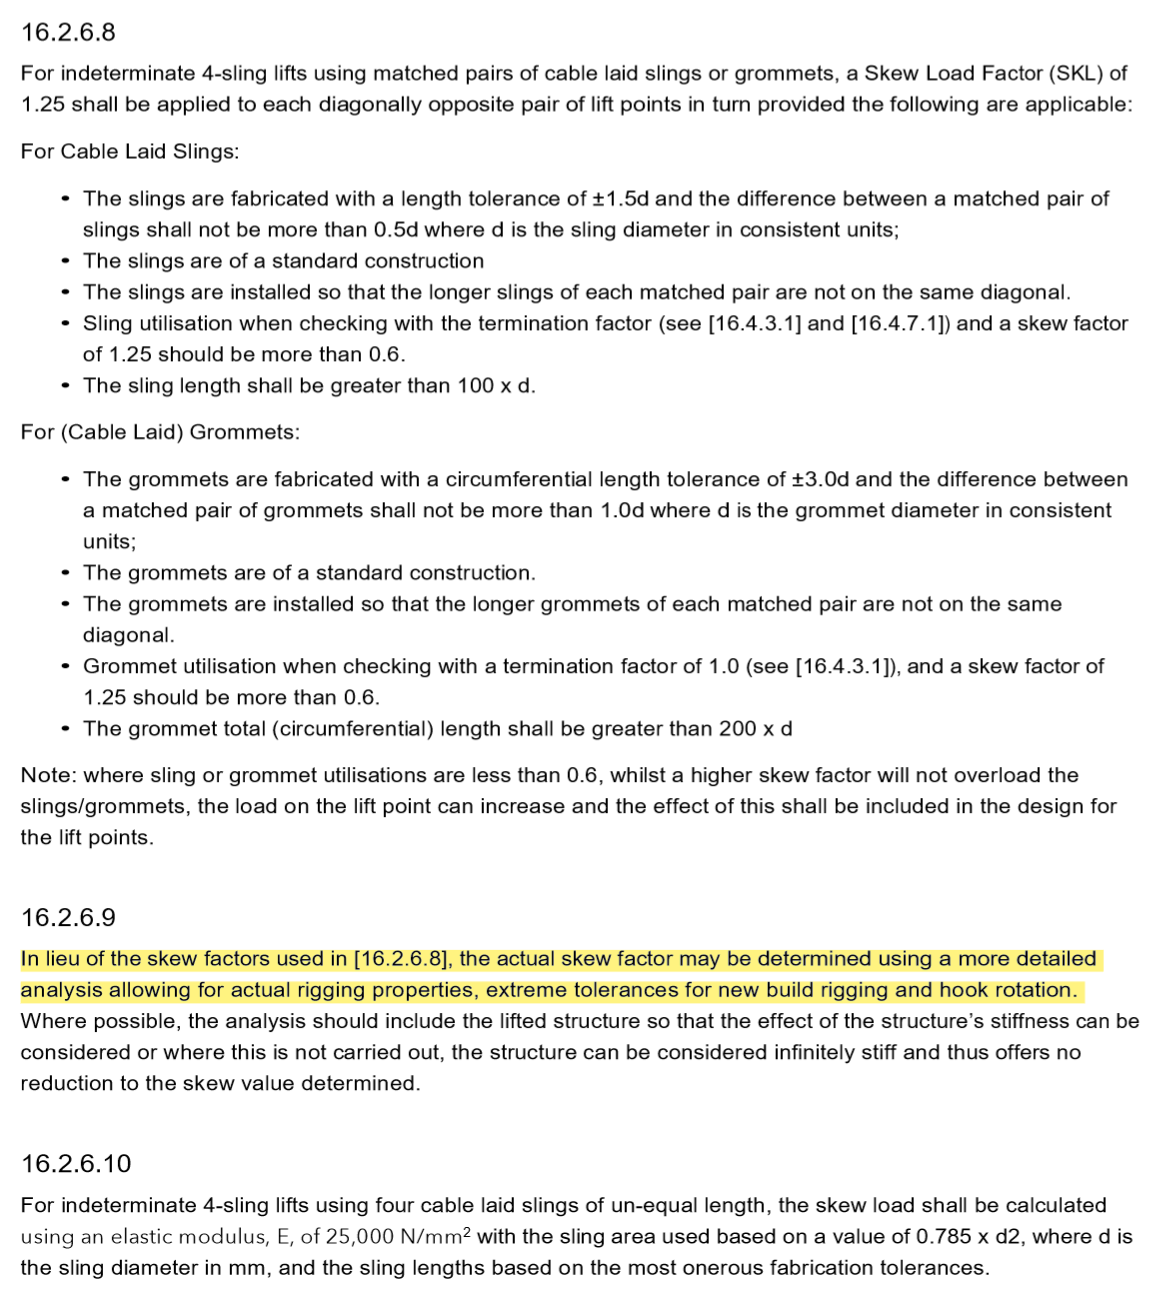

# Idea

We can set-up a load-case matrix using a pandas dataframe. [https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html]

For the rows we can use a multi-index with the node-name and node-property. For the columns we will use the load-case name or number.

In [3]:
import pandas as pd
import numpy as np

To illustrate the idea consider the following *example*:

In [4]:
properties = [('sling1','length'),
              ('sling1','EA'),
              ('sling3','length'),
             ('sling4','length')]
m_indx = pd.MultiIndex.from_tuples(properties, names = ['node','property'])

loadcase1 = pd.Series([1.1,2,3,4], index=m_indx)
loadcase2 = pd.Series([1,2.1,3,4], index = m_indx)

loadmatrix = pd.DataFrame({'loadcase 1':loadcase1,
                           'loadcase 2': loadcase2})


In this example we would have two load-cases.
Consider that the values in the base model would be 1,2,3 and 4.

The first load-case describes an increase in length of sling 1 by 10 cm.
The the second loadcase the describes an increase in stiffness of sling1 of 0.1 kN

## Rules

- for numbers that do not need to be changed relative to the base model, use np.nan as value

# Implementation

Get all the nodes of type sling from the model

In [5]:
slings = s.nodes_of_type(Sling)

Setup the list of properties

In [6]:
properties = []
for sling in slings:
    properties.append((sling.name,'length'))
    
m_indx = pd.MultiIndex.from_tuples(properties, names = ['node','property'])

m_indx

MultiIndex([('Sling1', 'length'),
            ('Sling2', 'length'),
            ('Sling3', 'length'),
            ('Sling4', 'length')],
           names=['node', 'property'])

For each property, determine the possible values. We will use -1 for a shorter sling, 0 for unchanged and +1 for a longer sling

In [7]:
individual_changes = []
for sling in slings:
    individual_changes.append([-1,0,1])

Now we can use the meshgrid function to create all possible combinations

In [8]:
combinations = np.meshgrid(*individual_changes)
combination_matrix = np.array(combinations).T.reshape(-1, len(properties))


The resuting array contains the applicable variations for all load-cases.

In [9]:
combination_matrix;  # large, remove ; to display

In [10]:
n_loadcases = combination_matrix.shape[0]
n_loadcases

81

We can now construct the loadcase matrix based on these variations

In [11]:
loadcases = dict()

variation_pct = 0.5 # variation of sling length in [%] of base length

n_loadcases = 16 # FOR TESTING ONLY you may manually lower this number

for i_loadcase in range(n_loadcases):
    
    variations = combination_matrix[i_loadcase,:]
    
    values = []
    
    for (prop, value) in zip(properties, variations):
        
        # get the base-case value
        node_name = prop[0]
        node_property = prop[1]
        
        if value == 0:
            values.append(np.nan)  # no change
        else:
            node = s[node_name]
            base_value = getattr(node, node_property)
            
            changed_value = base_value * (1 + value * variation_pct / 100)
            values.append(changed_value)
            
        
    # add to the dictionary
    loadcase_name = f'Loadcase {i_loadcase}'
    loadcases[loadcase_name] = pd.Series(values, index = m_indx)

loadcase_matrix = pd.DataFrame(loadcases)

In [12]:
loadcase_matrix.fillna('-').transpose()  # replace nans with '-' for nicer view and transpose for better fit

node          Sling1   Sling2   Sling3   Sling4
property      length   length   length   length
Loadcase 0   36.2287  36.2287  36.2287  36.2287
Loadcase 1   36.2287        -  36.2287  36.2287
Loadcase 2   36.2287  36.5928  36.2287  36.2287
Loadcase 3         -  36.2287  36.2287  36.2287
Loadcase 4         -        -  36.2287  36.2287
...              ...      ...      ...      ...
Loadcase 76        -        -  36.5928  36.5928
Loadcase 77        -  36.5928  36.5928  36.5928
Loadcase 78  36.5928  36.2287  36.5928  36.5928
Loadcase 79  36.5928        -  36.5928  36.5928
Loadcase 80  36.5928  36.5928  36.5928  36.5928

[81 rows x 4 columns]

# Running the variations

We can now run over the load-cases one by one, apply them, solve them and store the results.

We will not change the original model. Instead for each variation we create a temorary copy of the model and apply the variations on that.

We could get all the results, but that would be overwhelming. Instead we define the results that we want in the same way as we defined the 

In [13]:
requested_results = []
for sling in slings:
    requested_results.append((sling.name + '>>>_main_part','tension'))
    
for name in ['LP1_Corner','LP2_Corner','LP3_Corner','LP4_Corner']:
    requested_results.append((name,'connection_force_x'))
    requested_results.append((name,'connection_force_y'))
    requested_results.append((name,'connection_force_z'))
    
requested_results.append(('lifted_object','tilt_x'))
requested_results.append(('lifted_object','tilt_y'))
    
results_index = pd.MultiIndex.from_tuples(requested_results, names = ['node','property'])

results_index

MultiIndex([('Sling1>>>_main_part',            'tension'),
            ('Sling2>>>_main_part',            'tension'),
            ('Sling3>>>_main_part',            'tension'),
            ('Sling4>>>_main_part',            'tension'),
            (         'LP1_Corner', 'connection_force_x'),
            (         'LP1_Corner', 'connection_force_y'),
            (         'LP1_Corner', 'connection_force_z'),
            (         'LP2_Corner', 'connection_force_x'),
            (         'LP2_Corner', 'connection_force_y'),
            (         'LP2_Corner', 'connection_force_z'),
            (         'LP3_Corner', 'connection_force_x'),
            (         'LP3_Corner', 'connection_force_y'),
            (         'LP3_Corner', 'connection_force_z'),
            (         'LP4_Corner', 'connection_force_x'),
            (         'LP4_Corner', 'connection_force_y'),
            (         'LP4_Corner', 'connection_force_z'),
            (      'lifted_object',             'tilt_x'

## and go!

Depending on the complexity of the model and the number of loadcases, this may take a while.


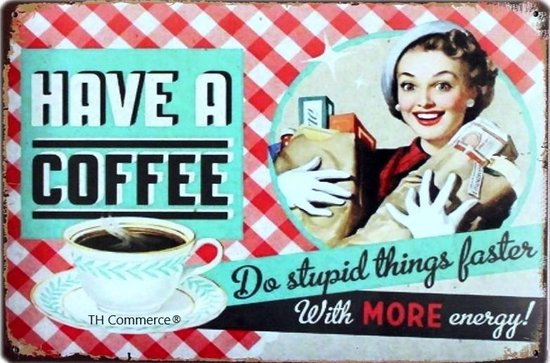

In [24]:
# This code looks intimidating - good thing there is no need to change it.
# So we could make a function for it (and then include multi-processing :-) )

n_processes = 12 # number of models to solve simultaneously

from multiprocessing.pool import ThreadPool

results_dict = {}

# Get the results from the base model
results = []
for props in requested_results:

    node_name = props[0]
    node = s[node_name]
    property_name = props[1]
    value = getattr(node, property_name)

    results.append(value)

results_dict['base_model'] = pd.Series(results, index = results_index)


def execute_variation(data):
    # Create a copy of the base scene
    
    loadcase_name = data[0]
    base_model_code = data[1]
    loadcase = data[2]
    requested_results = data[3]
    
    print('Running: ' + loadcase_name)
    temp_scene = Scene(code=base_model_code)  # creates a copy of s
    
    # loop over the index (the properties) and apply the values to the model
    for props, value in loadcase.items():
        
        if np.isnan(value):
            continue  # nan means keep original value (as agreed earlier)
            
        node_name = props[0]
        node = temp_scene[node_name]
        property_name = props[1]
        setattr(node, property_name, value)
        
    temp_scene.solve_statics()
    
    # we now have a solved model variation. Time to store some of the results
    results = []
    for props in requested_results:

        node_name = props[0]
        node = temp_scene[node_name]
        property_name = props[1]
        value = getattr(node, property_name)
        
        results.append(value)
        
    return results
    
base_model_code = s.give_python_code()

job_data = []
for loadcase_name in loadcase_matrix.columns:
    # print('----------------------')
    # print(loadcase_name)
    loadcase = loadcase_matrix[loadcase_name]
    job_data.append((loadcase_name, base_model_code, loadcase, requested_results))
    
with ThreadPool(processes=n_processes) as pool:
    result = pool.map(execute_variation, job_data)
    
# result is a list of results
# should be in same order as the input data

for i, loadcase_name in enumerate(loadcase_matrix.columns):
    results_dict[loadcase_name] = result[i]

results_matrix = pd.DataFrame(results_dict)     
        

Running: Loadcase 0
Running: Loadcase 2
Running: Loadcase 4
Running: Loadcase 6
Running: Loadcase 8
Running: Loadcase 10
Running: Loadcase 12
Running: Loadcase 14
Running: Loadcase 16
Running: Loadcase 18
Running: Loadcase 20
Running: Loadcase 22
Solved to 2.9216986149549484e-05.
Running: Loadcase 21
Solved to 1.0056246537715197e-06.
Running: Loadcase 23
Solved to 6.24277163296938e-08.
Running: Loadcase 11
Solved to 7.4575164035195485e-06.
Running: Loadcase 3
Solved to 1.5572382835671306e-05.
Running: Loadcase 9
Solved to 2.9186776373535395e-07.
Running: Loadcase 1
Solved to 3.2520329114049673e-06.
Running: Loadcase 5
Solved to 0.00020214209507685155.
Running: Loadcase 13
Solved to 9.931682143360376e-08.
Running: Loadcase 24
Solved to 1.8360151443630457e-06.
Running: Loadcase 17
Solved to 1.1006632121279836e-06.
Running: Loadcase 15
Solved to 4.879308835370466e-05.
Running: Loadcase 7
Solved to 0.0002738254770520143.
Running: Loadcase 26
Solved to 1.2376403901726007e-07.
Running: Loadc

# Now do something with the data

export to a spreadsheet (such as excel)

In [ ]:
results_matrix.to_csv(r"c:\data\results.csv")

or plot

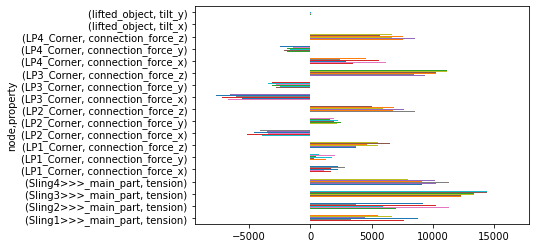

In [27]:
results_matrix.plot(kind='barh', legend = False)

Get results for a single loadcase

In [29]:
results_matrix['Loadcase 24']

node                 property          
Sling1>>>_main_part  tension                1181.509922
Sling2>>>_main_part  tension               12451.717123
Sling3>>>_main_part  tension                7913.023450
Sling4>>>_main_part  tension               13484.125156
LP1_Corner           connection_force_x      598.998144
                     connection_force_y      256.886421
                     connection_force_z      975.160980
LP2_Corner           connection_force_x    -6156.107338
                     connection_force_y     2847.524225
                     connection_force_z    10430.552032
LP3_Corner           connection_force_x    -3974.257492
                     connection_force_y    -1863.130592
                     connection_force_z     6571.977821
LP4_Corner           connection_force_x     6653.204813
                     connection_force_y    -3322.594975
                     connection_force_z    11237.189150
lifted_object        tilt_x                   -7.072086
        

Get resutls for a single node

In [30]:
results_transposed = results_matrix.transpose()  # transpose for easier indexing
lifted_object_data = results_transposed['lifted_object']

In [31]:
lifted_object_data

property       tilt_x     tilt_y
base_model  -6.959497   9.700071
Loadcase 0  -6.968497   9.753660
Loadcase 1  -6.508097   9.943085
Loadcase 2  -6.041112  10.140354
Loadcase 3  -6.556410   9.530046
...               ...        ...
Loadcase 76 -7.828147   9.677045
Loadcase 77 -7.349012   9.870595
Loadcase 78 -7.881051   9.261573
Loadcase 79 -7.403774   9.452390
Loadcase 80 -6.931811   9.650430

[82 rows x 2 columns]

Text(0.5, 1.0, 'Yes, the tilt is unacceptable')

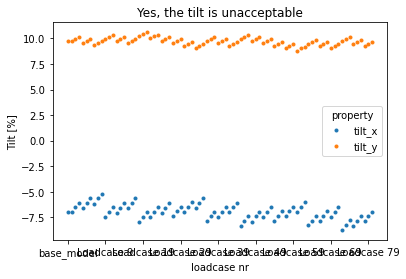

In [32]:
fig = lifted_object_data.plot(kind='line', style='.')
fig.set_xlabel('loadcase nr')
fig.set_ylabel('Tilt [%]')
fig.set_title('Yes, the tilt is unacceptable')

Summarize the data

In [34]:
results_transposed.describe().transpose()

count          mean          std  \
node                property                                               
Sling1>>>_main_part tension              82.0   5525.344535  1765.685912   
Sling2>>>_main_part tension              82.0   8111.139754  1766.552343   
Sling3>>>_main_part tension              82.0  12282.546432  1775.437800   
Sling4>>>_main_part tension              82.0   9120.185070  1774.310103   
LP1_Corner          connection_force_x   82.0   2759.692584   870.558639   
                    connection_force_y   82.0   1240.920299   412.848144   
                    connection_force_z   82.0   4612.551024  1480.506987   
LP2_Corner          connection_force_x   82.0  -4043.819246   865.750547   
                    connection_force_y   82.0   1823.228262   412.378379   
                    connection_force_z   82.0   6778.707374  1485.358970   
LP3_Corner          connection_force_x   82.0  -6107.644919   862.930428   
                    connection_force_y   82.0  -2930.367653   448.673819   
                    connection_force_z   82.0  10232.882334  1489.199685   
LP4_Corner          connection_force_x   82.0   4536.218746   866.364413   
                    connection_force_y   82.0  -2180.510974   454.413318   
                    connection_force_z   82.0   7594.424973  1482.568698   
lifted_object       tilt_x               82.0     -6.954570     0.727542   
                    tilt_y               82.0      9.702864     0.365262   

                                                min           25%  \
node                property                                        
Sling1>>>_main_part tension             1181.509922   4428.901118   
Sling2>>>_main_part tension             3755.415093   7003.393980   
Sling3>>>_main_part tension             7913.023450  11169.564497   
Sling4>>>_main_part tension             4748.459624   8022.232595   
LP1_Corner          connection_force_x   598.998144   2218.802267   
                    connection_force_y   256.886421    973.704433   
                    connection_force_z   975.160980   3689.283697   
LP2_Corner          connection_force_x -6156.107338  -4598.496925   
                    connection_force_y   830.395870   1552.732355   
                    connection_force_z  3122.658537   5842.109166   
LP3_Corner          connection_force_x -8219.949224  -6660.193934   
                    connection_force_y -4040.576900  -3242.677150   
                    connection_force_z  6571.977821   9300.666304   
LP4_Corner          connection_force_x  2388.058053   3993.862796   
                    connection_force_y -3322.594975  -2487.869381   
                    connection_force_z  3942.937136   6682.362498   
lifted_object       tilt_x                -8.723741     -7.413553   
                    tilt_y                 8.808952      9.457013   

                                                 50%           75%  \
node                property                                         
Sling1>>>_main_part tension              5528.020635   6610.026227   
Sling2>>>_main_part tension              8119.323365   9216.321900   
Sling3>>>_main_part tension             12282.846917  13397.900650   
Sling4>>>_main_part tension              9127.910936  10214.360338   
LP1_Corner          connection_force_x   2762.287678   3311.034633   
                    connection_force_y   1234.281599   1510.423707   
                    connection_force_z   4611.502495   5532.075736   
LP2_Corner          connection_force_x  -4050.313116  -3503.708499   
                    connection_force_y   1820.327067   2099.783224   
                    connection_force_z   6775.265376   7718.019778   
LP3_Corner          connection_force_x  -6101.340924  -5566.622564   
                    connection_force_y  -2927.304718  -2622.876502   
                    connection_force_z  10238.382334  11167.899536   
LP4_Corner          connection_force_x   4540.323882   5086.753075   
                  

--- finished ---